In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

### Load the Dataset And Data Exploring

In [2]:
money_df = pd.read_csv("Moneylaundering.csv")

In [3]:
money_df.shape

(6362620, 11)

In [4]:
df = money_df.sample(n=100000, random_state=1)

df.shape

(100000, 11)

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6322570,688,CASH_IN,23557.12,C867750533,8059.00,31616.12,C1026934669,169508.66,145951.53,0,0
3621196,274,PAYMENT,6236.13,C601099070,0.00,0.00,M701283411,0.00,0.00,0,0
1226256,133,PAYMENT,33981.87,C279540931,18745.72,0.00,M577905776,0.00,0.00,0,0
2803274,225,CASH_OUT,263006.42,C11675531,20072.00,0.00,C529577791,390253.56,653259.98,0,0
3201247,249,CASH_OUT,152013.74,C530649214,20765.00,0.00,C1304175579,252719.19,404732.93,0,0


In [6]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4225513,306,CASH_OUT,15627.09,C1059072914,81424.0,65796.91,C759673946,0.00,15627.09,0,0
4989642,352,PAYMENT,4539.99,C1543222456,31492.0,26952.01,M441713839,0.00,0.00,0,0
2099701,182,CASH_IN,182400.10,C171437065,1060.0,183460.10,C1175649845,0.00,0.00,0,0
249322,14,PAYMENT,3673.04,C1831253634,19837.0,16163.96,M912660596,0.00,0.00,0,0
4679267,331,CASH_OUT,59171.56,C41194212,14964.0,0.00,C724844824,87121.42,146292.98,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 6322570 to 4679267
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.2+ MB


In [8]:
print(f'number of rows : {df.shape[0]}  \nnumber of columns : {df.shape[1]}')

number of rows : 100000  
number of columns : 11


### Handling missing values

In [9]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


<Axes: xlabel='type', ylabel='count'>

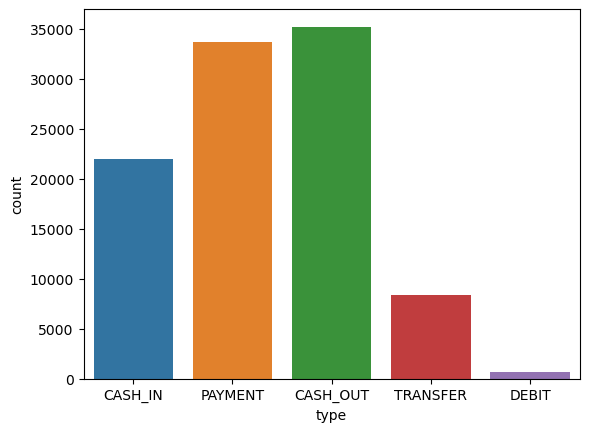

In [10]:
sns.countplot(data=df, x='type')

### Convert Categorical Data

In [11]:
# Convert the 'Type' column to numerical values using one-hot encoding
df = pd.get_dummies(df, columns=['type'], drop_first=True)

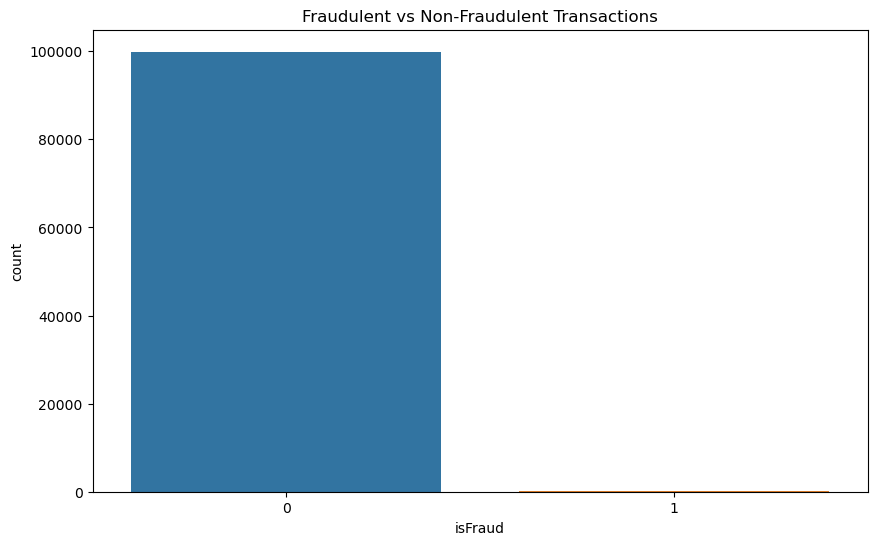

In [12]:
# Count plot for fraudulent vs non-fraudulent transactions
plt.figure(figsize=(10,6))
sns.countplot(x='isFraud', data=df)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.show()

### Feature Engineering

In [13]:
# Feature: Difference between old and new balance for originator and recipient
df['OrigBalanceDiff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['DestBalanceDiff'] = df['oldbalanceDest'] - df['newbalanceDest']



In [14]:
# Feature: Ratio of transaction amount to original balance
df['AmountToOrigBalanceRatio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['AmountToDestBalanceRatio'] = df['amount'] / (df['oldbalanceDest'] + 1)

### Split the Data into Training and Testing Sets

In [15]:
from sklearn.model_selection import train_test_split
# Define the features and target variable
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'])
y = df['isFraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Handle Data Imbalance

In [16]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Model Training

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

#### Evaluate the model

In [18]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19975
           1       0.96      1.00      0.98        25

    accuracy                           1.00     20000
   macro avg       0.98      1.00      0.99     20000
weighted avg       1.00      1.00      1.00     20000

[[19974     1]
 [    0    25]]
ROC AUC Score: 0.9999749687108885


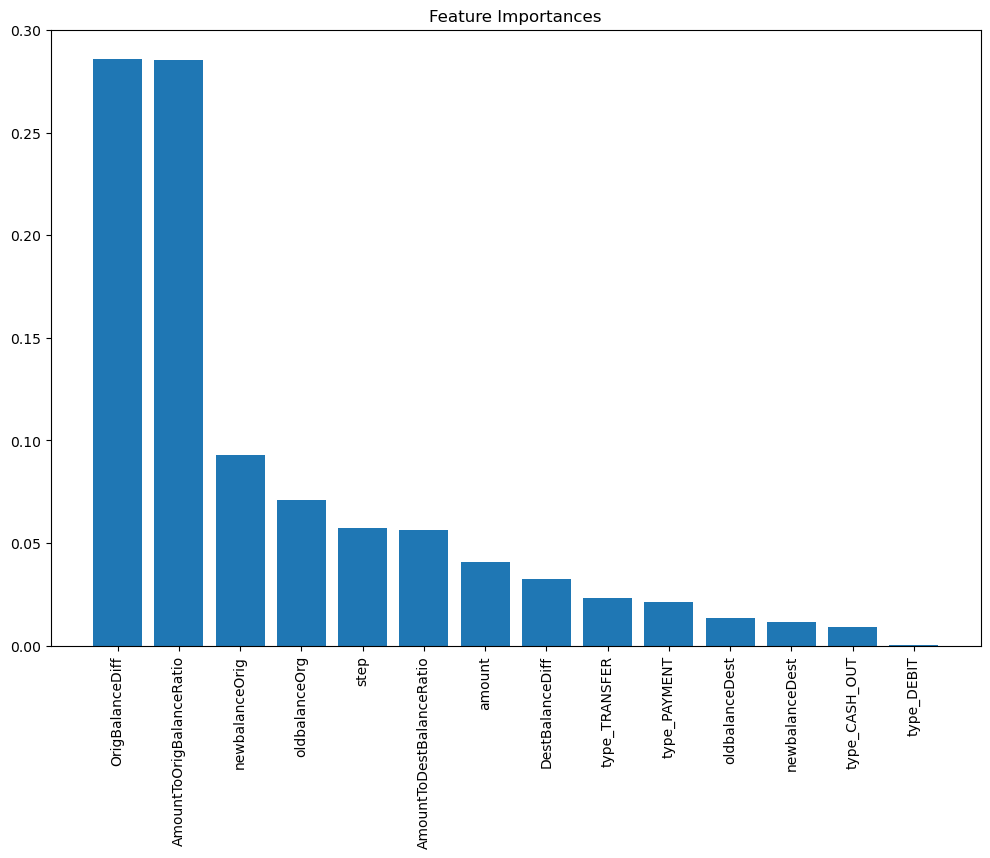

In [19]:
 # Feature importances from random forest

importances = rf_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

#### Confusion Matrix

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19975
           1       0.96      1.00      0.98        25

    accuracy                           1.00     20000
   macro avg       0.98      1.00      0.99     20000
weighted avg       1.00      1.00      1.00     20000

ROC AUC Score: 0.9999749687108885


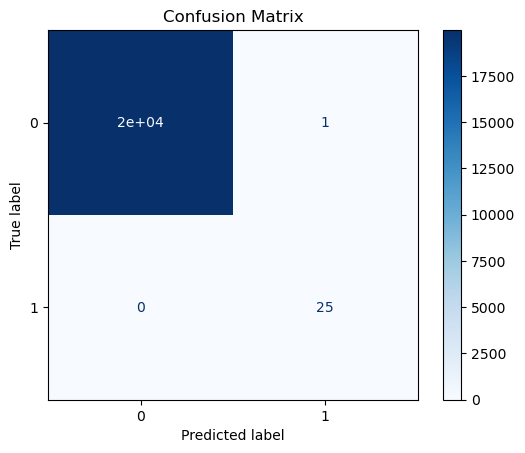

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix')
plt.show()


#### Roc Curve

In [21]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

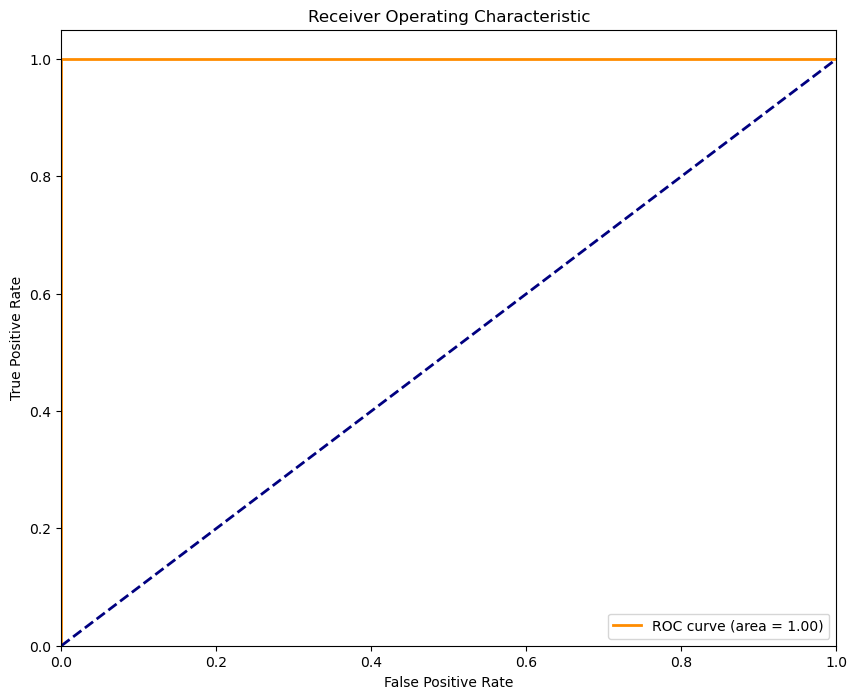

In [22]:
# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

# Initialize and train the SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_res, y_train_res)

In [ ]:
# Evaluate the model
print("SVM Performance")
print(classification_report(y_test, y_pred_svm))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_svm))


In [ ]:
# Compute confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)


In [ ]:
# Plot confusion matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot(cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

In [ ]:
# Calculate and plot ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.predict_proba(X_test)[:,1])
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(10,8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_res, y_train_res)

In [ ]:
# Make predictions
y_pred_lr = lr_model.predict(X_test)

In [ ]:
# Evaluate the model
print("Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_lr))

In [ ]:
# Compute confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

In [ ]:
# Plot confusion matrix
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [ ]:
# Calculate and plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(10,8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()